# Assignment-4(AI)
## Question-2 Decision Tree Model for Price Prediction

- **Objective**: To preprocess the dataset, handle imbalanced data, train a decision tree, optimize it, and evaluate its performance.
- **Dataset**: Provided `train.csv` and `test.csv`.
- **Libraries Used**: NumPy, Pandas, Scikit-learn, Imbalanced-learn, Matplotlib, Seaborn.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## Step 1: Load Data
The dataset is split into `train.csv` for training and `test.csv` for testing.


In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (6256, 15)
Testing Data Shape: (1564, 15)


## Step 2: Exploratory Data Analysis (EDA)
### Task 1: Understanding the Dataset
- Summarizing unique values in columns.
- Performing statistical analysis on numerical columns.


In [6]:
# Overview and Statistics
print(train_data.info())
print(train_data.describe())
print(train_data.nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6256 non-null   int64  
 1   Address         6256 non-null   object 
 2   Possesion       6256 non-null   object 
 3   Furnishing      6256 non-null   object 
 4   Buildup_area    6256 non-null   float64
 5   Carpet_area     6256 non-null   float64
 6   Bathrooms       6256 non-null   float64
 7   Property_age    6256 non-null   int64  
 8   Parking         6256 non-null   int64  
 9   Price           6256 non-null   int64  
 10  Brokerage       6256 non-null   float64
 11  Floor           6256 non-null   float64
 12  Per_sqft_price  6256 non-null   float64
 13  BHK             6256 non-null   float64
 14  Total_bedrooms  6256 non-null   float64
dtypes: float64(8), int64(4), object(3)
memory usage: 733.2+ KB
None
             index  Buildup_area   Carpet_area    Bathrooms

### Task 2: Dropping Irrelevant Columns
- Using correlation analysis to remove features with low predictive power.


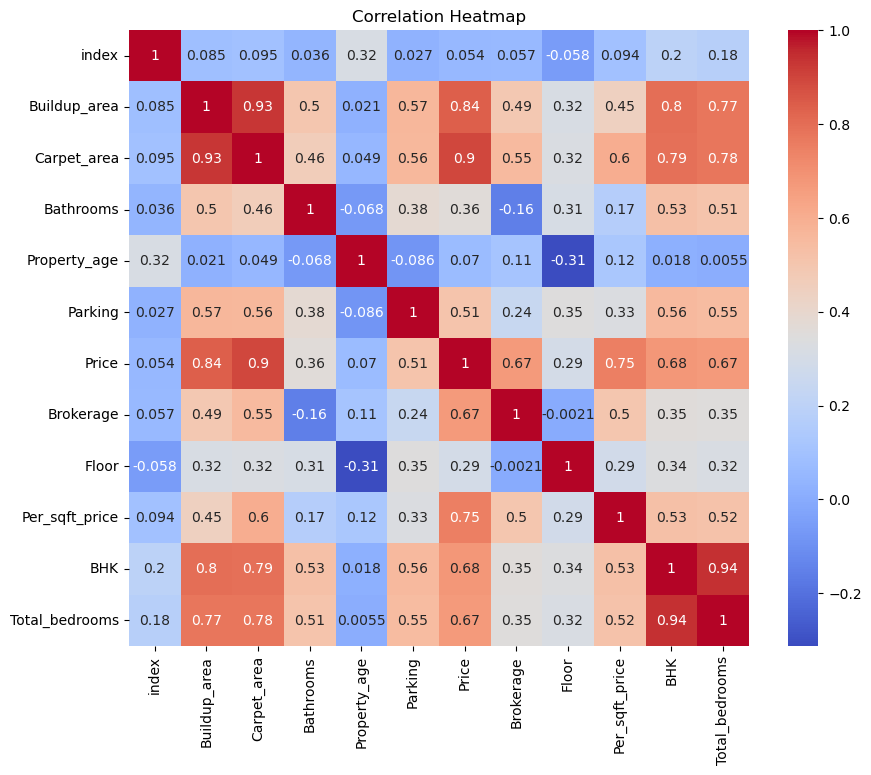

Dropped columns based on low correlation: ['index', 'Property_age']


In [7]:
# Compute correlation matrix for numeric columns
corr_matrix = train_data.select_dtypes(include=['float64', 'int64']).corr()

# Visualize the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Identify and drop columns with low correlation with the target variable
target_col = 'Price'  # Replace with your actual target column name
low_corr_cols = corr_matrix[target_col][corr_matrix[target_col].abs() < 0.1].index.tolist()

# Drop low-correlation columns
train_data = train_data.drop(columns=low_corr_cols, errors='ignore')
test_data = test_data.drop(columns=low_corr_cols, errors='ignore')

print(f"Dropped columns based on low correlation: {low_corr_cols}")


### Task 3: Encoding Categorical Features
- Applying Label Encoding to transform categorical columns into numerical values.
(Needs Recheck)

In [8]:
# Encode categorical columns using pd.factorize
for col in train_data.select_dtypes(include=['object']).columns:
    all_values = pd.concat([train_data[col], test_data[col]], axis=0)
    train_data[col], uniques = pd.factorize(train_data[col])
    test_data[col] = pd.Categorical(test_data[col], categories=uniques).codes


### Task 4: Feature Scaling
- Applying StandardScaler to numerical columns.


In [9]:
scaler = StandardScaler()
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])


### Task 5: Target Variable Imbalance Detection
- Plotting the distribution of the target variable.
- Categorizing prices into bins: Low, Medium, High, Very High.


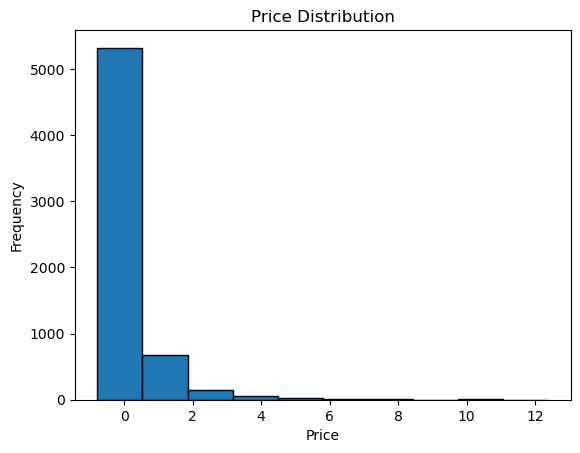

Low          1874
Medium          0
High            0
Very High       0
Name: Price_Category, dtype: int64


In [10]:
# Plot Price Distribution
plt.hist(train_data['Price'], bins=10, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

# Create Bins for Price
bins = [0, 100000, 200000, 500000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']
train_data['Price_Category'] = pd.cut(train_data['Price'], bins=bins, labels=labels)
print(train_data['Price_Category'].value_counts())


### Task 6: Handling Imbalanced Data
- Using Random Oversampling and Undersampling to balance the dataset.


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Adjust binning for Price_Category using quantiles
train_data['Price_Category'] = pd.qcut(train_data['Price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Check class distribution
print(train_data['Price_Category'].value_counts())

# Ensure target variable is categorical
y = train_data['Price_Category']

# Features and target
X = train_data.drop(['Price', 'Price_Category'], axis=1)

# Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print("After Oversampling:", pd.Series(y_resampled).value_counts())

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("After Undersampling:", pd.Series(y_resampled).value_counts())


High         1599
Low          1567
Medium       1566
Very High    1524
Name: Price_Category, dtype: int64
After Oversampling: Low          1599
Medium       1599
High         1599
Very High    1599
Name: Price_Category, dtype: int64
After Undersampling: Low          1524
Medium       1524
High         1524
Very High    1524
Name: Price_Category, dtype: int64


## Question-3 Building Decision Tree Model

**Objective**:  
1. Train a Decision Tree Regressor.  
2. Optimize the model using hyperparameters.  
3. Handle overfitting with pruning and cross-validation.  
4. Analyze feature importances and evaluate performance.  

**Libraries Used**:
- matplotlib
- numpy
- pandas

### Task 1: Model Training

We train a Decision Tree Regressor on the training data and visualize its structure.


Training Mean Squared Error: 5.5641046331393005e-14


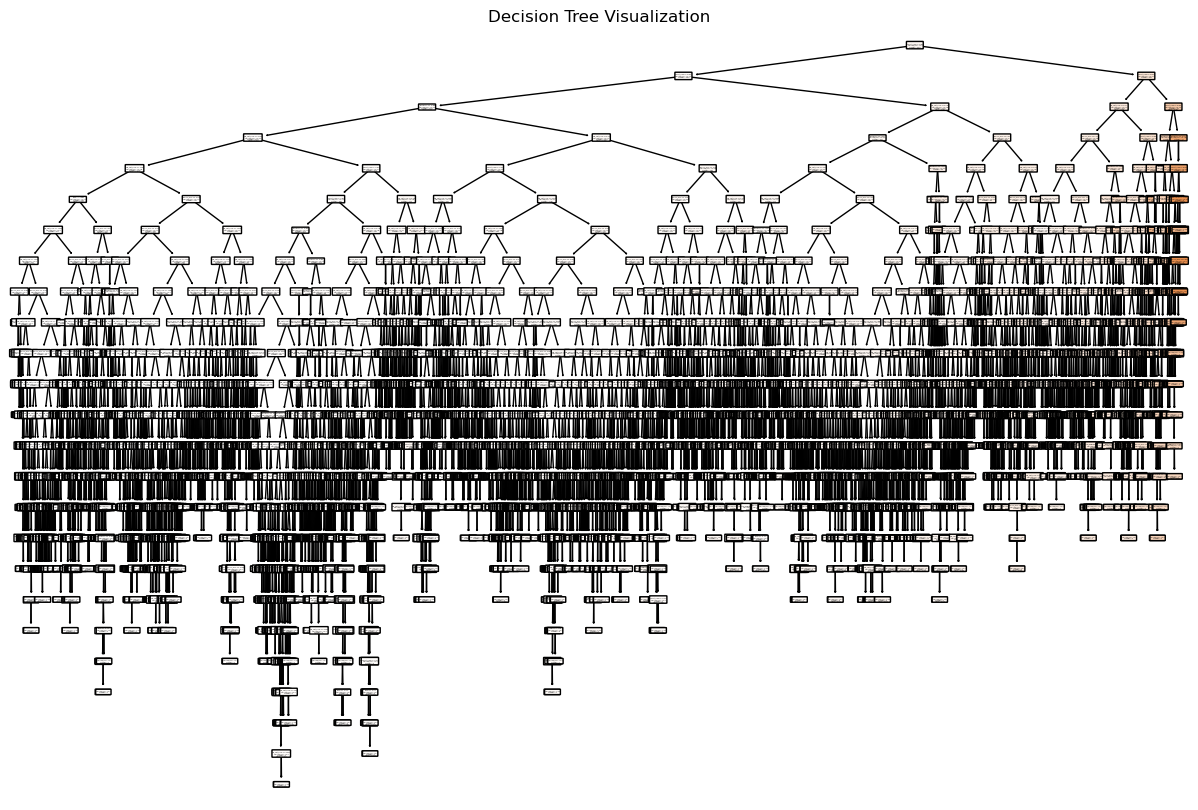

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error

# Splitting features and target
X_train = train_data.drop(['Price', 'Price_Category'], axis=1)
y_train = train_data['Price']

# Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate on training data
y_train_pred = dt_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

# Visualize the Decision Tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


### Task 2: Feature Importance and Hyperparameter Tuning

1. Extract and visualize feature importance.
2. Perform hyperparameter optimization using GridSearchCV.


           Feature  Importance
4      Carpet_area    0.801791
9   Per_sqft_price    0.091981
7        Brokerage    0.060191
3     Buildup_area    0.038980
5        Bathrooms    0.002936
11  Total_bedrooms    0.002321
0          Address    0.001188
8            Floor    0.000244
6          Parking    0.000235
2       Furnishing    0.000091
10             BHK    0.000043
1        Possesion    0.000000


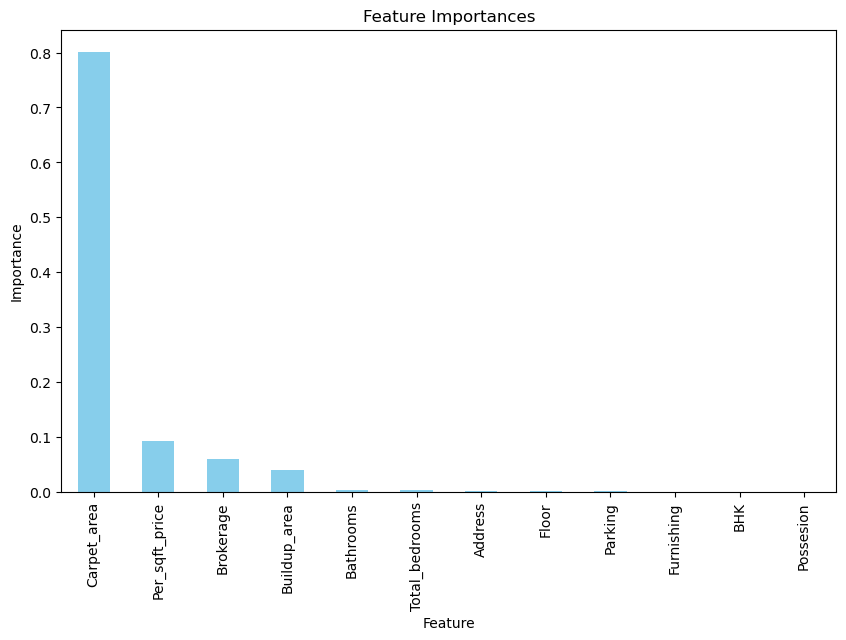

In [13]:
# Extract and visualize feature importance
import pandas as pd

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Plot feature importance
feature_importances.plot(kind='bar', x='Feature', y='Importance', legend=False, color='skyblue', figsize=(10, 6))
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV for Decision Tree
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_train_best_pred = best_model.predict(X_train)
best_mse = mean_squared_error(y_train, y_train_best_pred)
print(f"Best Model Training MSE: {best_mse}")


Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Model Training MSE: 0.007288754800982903


### Task 3: Pruning Decision Tree

We prune the Decision Tree using cost-complexity pruning and visualize the pruned tree.


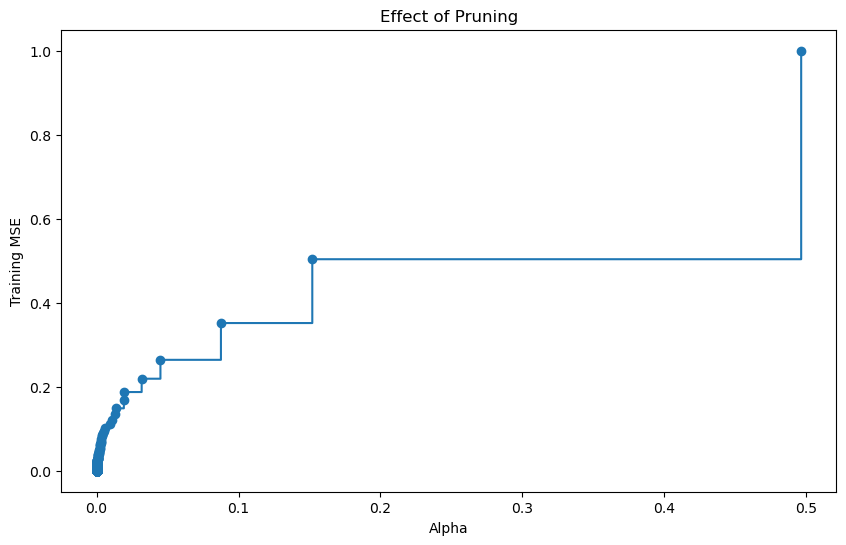

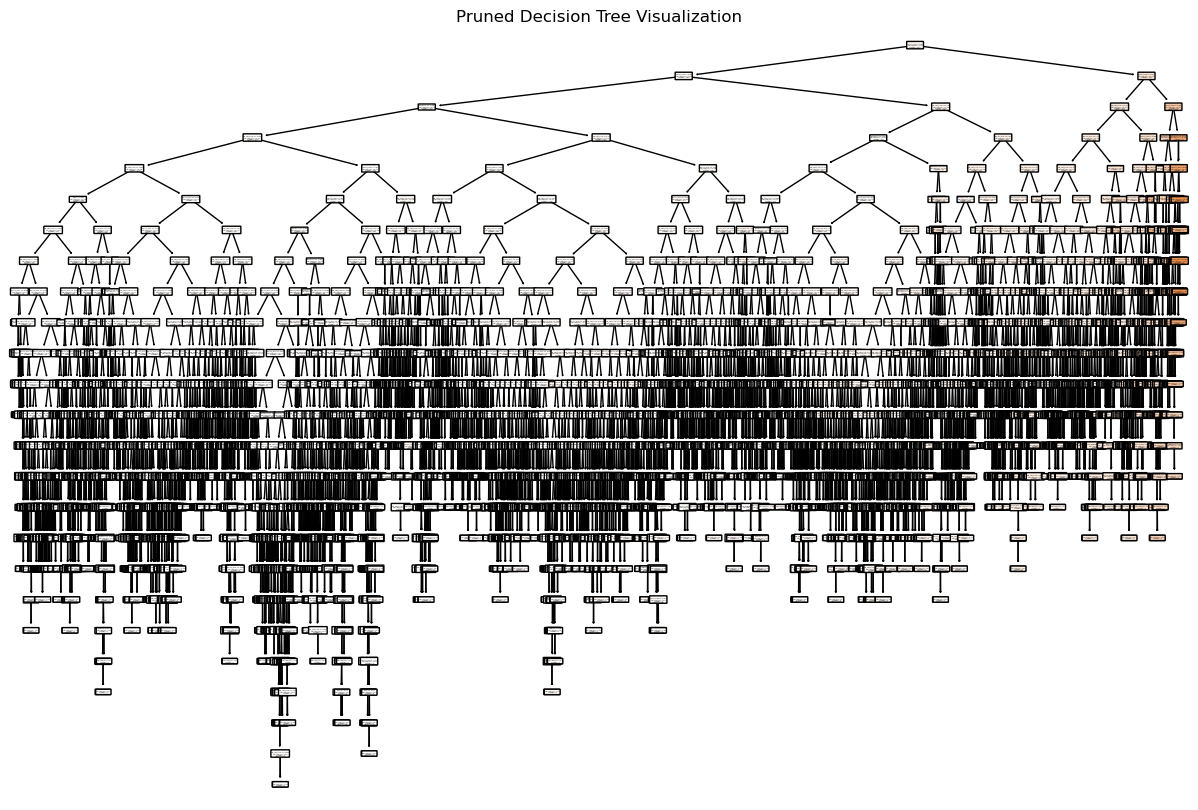

In [15]:
# Cost-Complexity Pruning
path = dt_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # Effective alphas for pruning
impurities = path.impurities

# Train models for each alpha
pruned_models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    pruned_models.append(model)

# Evaluate pruned models
pruned_scores = [mean_squared_error(y_train, model.predict(X_train)) for model in pruned_models]

# Plot pruning results
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, pruned_scores, marker='o', drawstyle='steps-post')
plt.xlabel("Alpha")
plt.ylabel("Training MSE")
plt.title("Effect of Pruning")
plt.show()

# Visualize a pruned tree
plt.figure(figsize=(15, 10))
plot_tree(pruned_models[5], filled=True, feature_names=X_train.columns, rounded=True)
plt.title("Pruned Decision Tree Visualization")
plt.show()


### Task 4: Handling Overfitting

We address overfitting using cross-validation and learning curves.


In [16]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation Scores:", -cv_scores)
print("Mean CV Score:", -np.mean(cv_scores))


Cross-Validation Scores: [0.01434755 0.03465559 0.02860668 0.07135133 0.06305302]
Mean CV Score: 0.04240283377902743


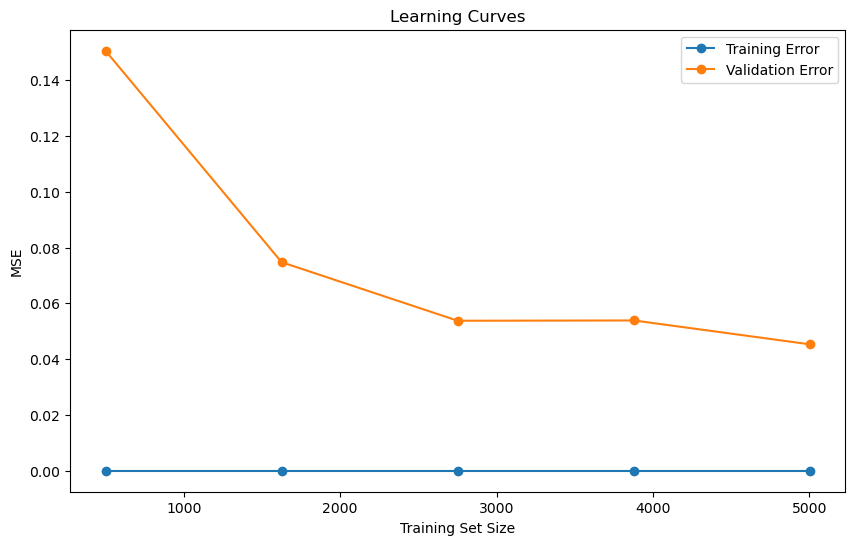

In [17]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Plot learning curves
train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes, val_errors, label='Validation Error', marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.title("Learning Curves")
plt.legend()
plt.show()


## Question 4: Model Evaluation and Error Analysis

Objectives:
1. Evaluate the tuned model using regression metrics.
2. Analyze residuals and visualize error patterns.
3. Perform feature importance-based analysis for the top 3 features.


### Task 1: Model Evaluation

We evaluate the tuned Decision Tree model on both the training and test datasets using:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R-squared (R²)


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Recreate Price_Category in test_data if needed
if 'Price_Category' not in test_data.columns:
    bins = [0, 100000, 200000, 500000, float('inf')]
    labels = ['Low', 'Medium', 'High', 'Very High']
    test_data['Price_Category'] = pd.cut(test_data['Price'], bins=bins, labels=labels)

# Define test features and target
X_test = test_data.drop(columns=[col for col in ['Price', 'Price_Category'] if col in test_data.columns])
y_test = test_data['Price']

# Predictions on test data
y_test_pred = best_model.predict(X_test)

# Regression metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test R-squared (R²): {test_r2}")

# Evaluate on training data
y_train_best_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_best_pred)
train_r2 = r2_score(y_train, y_train_best_pred)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Training R-squared (R²): {train_r2}")


Test Mean Squared Error (MSE): 0.006046737620256691
Test Mean Absolute Error (MAE): 0.027183394014886442
Test R-squared (R²): 0.9925654256301152
Training Mean Squared Error (MSE): 0.007288754800982903
Training R-squared (R²): 0.9927112451990171


#### Model Performance Interpretation:
- **Training Data**:
  - MSE and R² indicate the model’s performance on the training data.
  - Lower MSE and higher R² indicate better performance.

- **Test Data**:
  - Comparing metrics on training and test data helps identify overfitting or underfitting.
  - Significant differences between training and test performance might indicate overfitting.


### Task 2: Residual and Error Analysis

Residual analysis is performed to:
- Check for patterns in prediction errors.
- Identify groups of data where the model consistently underperforms.


count    1564.000000
mean        0.002817
std         0.077735
min        -1.121373
25%        -0.006596
50%         0.000000
75%         0.007916
max         0.956465
Name: Price, dtype: float64


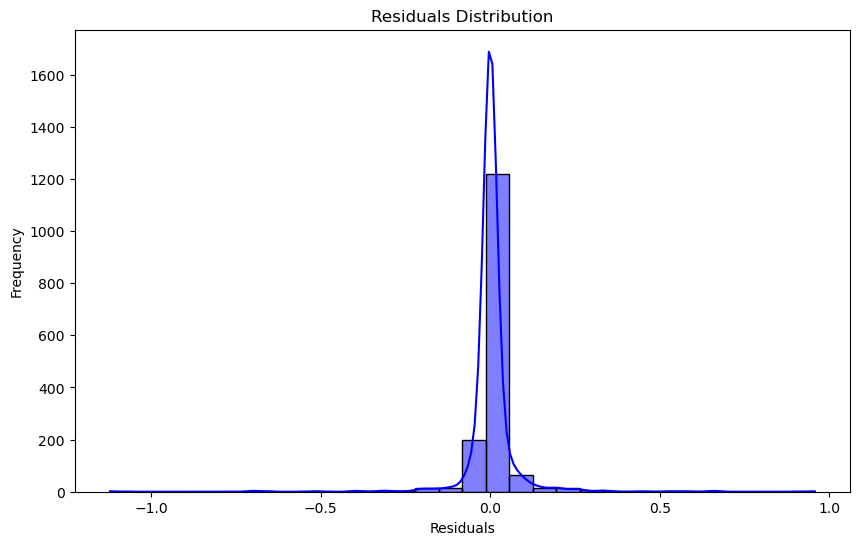

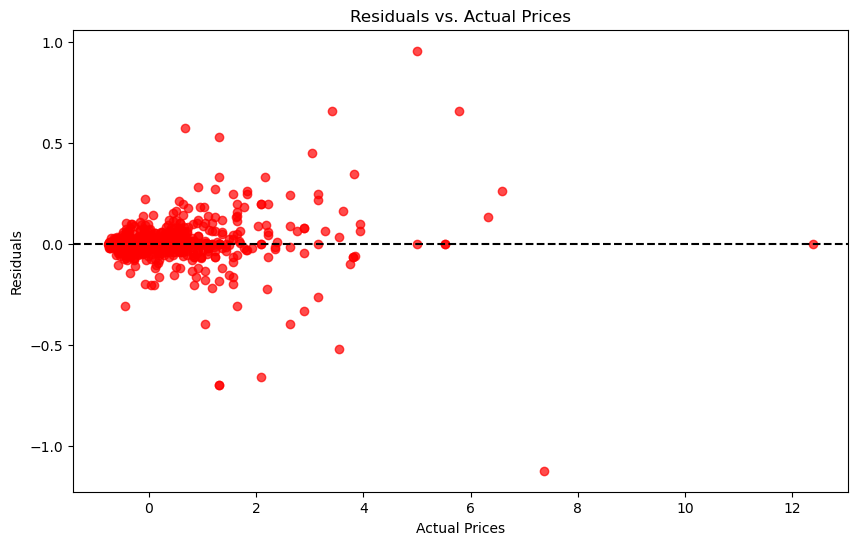

In [19]:
# Residuals calculation
residuals = y_test - y_test_pred

# Summary of residuals
print(residuals.describe())

# Visualize residuals
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Residuals scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals vs. Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()


#### Residual Patterns:
- The histogram shows whether residuals are centered around 0.
- The scatter plot helps detect trends (e.g., underestimation for higher prices).

#### Proposed Improvements:
- If residuals show a trend, consider using a more complex model like Random Forest.
- Address feature interactions or try polynomial features to capture non-linear relationships.


### Task 3: Feature Importance-Based Analysis

We analyze the top 3 important features to see how they individually affect the target variable and calculate the RMSE.


Top 3 Features: ['Carpet_area', 'Per_sqft_price', 'Brokerage']
RMSE for Carpet_area: 0.31934116124945117


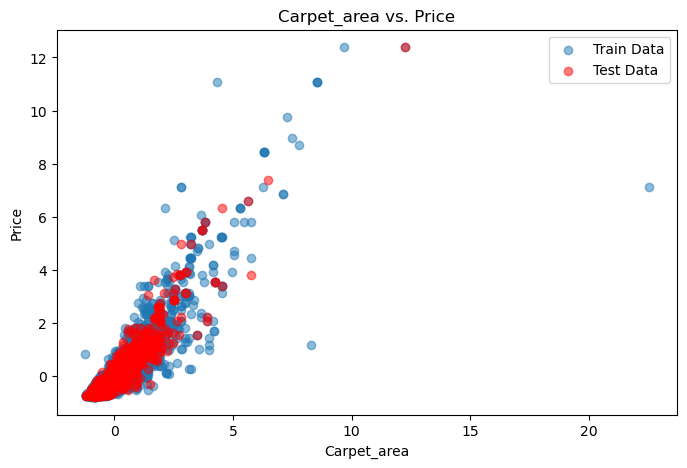

RMSE for Per_sqft_price: 0.7518858925629108


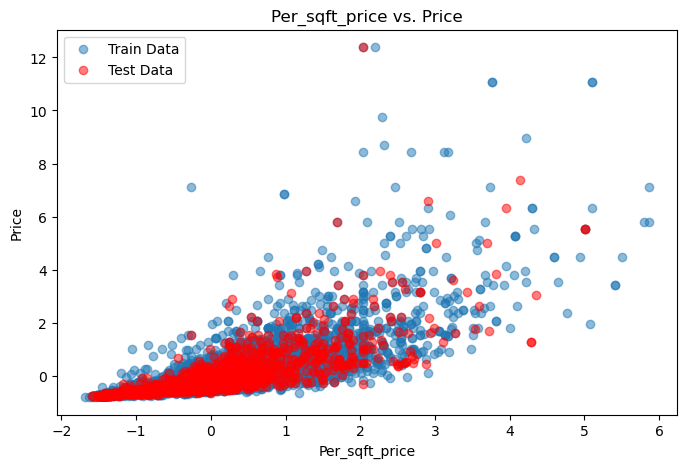

RMSE for Brokerage: 0.5086178031757013


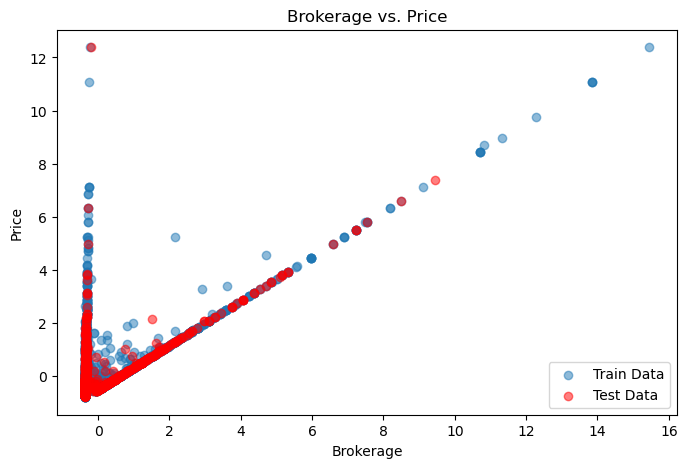

In [20]:
# Top 3 important features
top_features = feature_importances['Feature'].head(3)
print("Top 3 Features:", top_features.tolist())

# Individual feature analysis
from sklearn.metrics import mean_squared_error

for feature in top_features:
    # Simple model with a single feature
    X_single = X_train[[feature]]
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_single, y_train)

    # Predictions and RMSE
    y_test_single_pred = model.predict(X_test[[feature]])
    rmse = mean_squared_error(y_test, y_test_single_pred, squared=False)
    print(f"RMSE for {feature}: {rmse}")

    # Plot feature vs. price
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train[feature], y_train, alpha=0.5, label='Train Data')
    plt.scatter(X_test[feature], y_test, alpha=0.5, label='Test Data', color='red')
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"{feature} vs. Price")
    plt.legend()
    plt.show()


#### Observations:
- **Feature Analysis**:
  - The scatter plots indicate the relationship between each top feature and the target variable.
  - RMSE highlights the individual predictive power of each feature.

- **Insights**:
  - Features with strong relationships to the target (e.g., high importance) contribute more to the model’s predictions.
